<a href="https://colab.research.google.com/github/heisengit/MachineLearning/blob/master/Keras_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Example

## Imports & data set

CIFAR-10
From Wikipedia, the free encyclopedia

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

In [0]:
#Import libraries

import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.applications import VGG16

#Download dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


### Pixels scaling

In [0]:
# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

### Validation split

Using the stratify parameter in the `train_test_split` function the splits are made by preserving the percentage of samples for each class (a priori distribution).

In [0]:
#Split the dataset into train and validation
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.20, stratify=y_train)

print(x_train.shape, x_valid.shape, x_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


### Ground truth 
To train a Keras model, the ground truth has to be in the categorical form ( e.g. [0.0,1.0,0.0,0.0] )

In [0]:
print(y_train.shape, y_valid.shape, y_test.shape)

y_train = to_categorical(y_train,num_classes=10)
y_valid = to_categorical(y_valid,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

print(y_train.shape, y_valid.shape, y_test.shape)

(40000, 1) (10000, 1) (10000, 1)
(40000, 10) (10000, 10) (10000, 10)


## Training mode

In [0]:
#@title Select the network to use. { display-mode: "form" }

mode = "Custom network" #@param ["Fine tuning", "Custom network"]

## Custom CNN Definition

In [0]:
if mode == 'Custom network':
  model = Sequential()

  # Convolutional layers
  model.add(Conv2D(1, (3,3), padding='same',activation='relu', input_shape=x_train.shape[1:]))
  model.add(MaxPooling2D(pool_size=(2, 2),stride=3))
  model.add(Dropout(0.2))

  model.add(Conv2D(1, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # Vectorize features
  model.add(Flatten())

  # MLP Layers
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  model.summary()

TypeError: ignored

## Fine Tuning (VGG16)
VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

In [0]:
if mode == "Fine tuning":
  # Load the VGG16 network without the top (dense) layers
  vgg = VGG16(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
  # Disable training for this network
  vgg.trainable = False

  # Add VGG16 as a layer in a Sequential model
  model=Sequential()
  model.add(vgg)
  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))

  model.summary()

## Training


### Parameters

In [0]:
#{ display-mode: "form" }

n_epochs = 100 #@param {type:"integer"}
batch_size = 256 #@param {type:"integer"}
learning_rate = 0.01 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
early_stopping = True #@param ["True", "False"] {type:"raw"}
patience = 5 #@param {type:"integer"}

### Optimizer and Early stoppping initialization

In [0]:
# Let's train the model using SGD (stochastic gradient descent)
opt = SGD(learning_rate,momentum)
model.compile(
  loss='categorical_crossentropy',
  optimizer = opt,
  metrics=['accuracy']
)

# Early stopping
callbacks = [] if not early_stopping else [ EarlyStopping(
    monitor='val_loss',  
    patience=patience, 
    restore_best_weights=True
  )
]

### Training method
The `fit()` method on a Keras Model returns a `History` object. The History.history attribute is a dictionary recording training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable). 

In [0]:
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_valid,y_valid), 
    epochs=n_epochs,
    callbacks = callbacks,
    batch_size=batch_size, 
    verbose=1
  )

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 5s 115us/step - loss: 2.0942 - acc: 0.2312 - val_loss: 1.8725 - val_acc: 0.3529
Epoch 2/100
40000/40000 [==============================] - 4s 97us/step - loss: 1.7948 - acc: 0.3579 - val_loss: 1.6492 - val_acc: 0.4084
Epoch 3/100
40000/40000 [==============================] - 4s 98us/step - loss: 1.6287 - acc: 0.4116 - val_loss: 1.5389 - val_acc: 0.4551
Epoch 4/100
40000/40000 [==============================] - 4s 98us/step - loss: 1.5467 - acc: 0.4439 - val_loss: 1.5001 - val_acc: 0.4675
Epoch 5/100
40000/40000 [==============================] - 4s 97us/step - loss: 1.4633 - acc: 0.4755 - val_loss: 1.3832 - val_acc: 0.5081
Epoch 6/100
40000/40000 [==============================] - 4s 98us/step - loss: 1.3984 - acc: 0.4964 - val_loss: 1.2959 - val_acc: 0.5375
Epoch 7/100
40000/40000 [==============================] - 4s 98us/step - loss: 1.3429 - acc: 0.5157 - val_loss: 1.2448 -

### Curves visualization


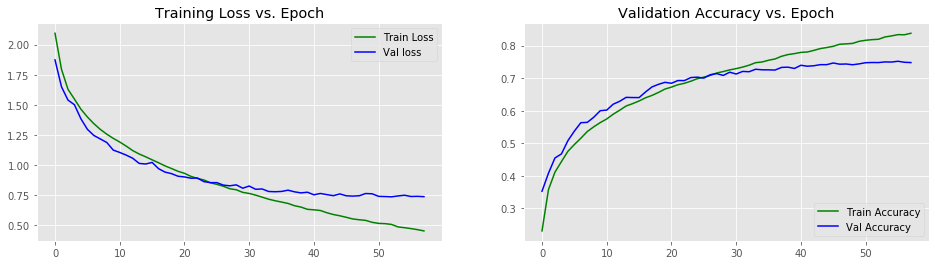

In [0]:
# For visually better looking plots
import matplotlib.pyplot as plt
# Changing default figure size for properly accomodating images
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title('Training Loss vs. Epoch')
ax2.set_title('Validation Accuracy vs. Epoch')

ax1.plot(history.history['loss'], color='green', label='Train Loss')
ax1.plot(history.history['val_loss'], color='blue', label='Val loss')

ax2.plot(history.history['acc'], color='green', label='Train Accuracy')
ax2.plot(history.history['val_acc'], color='blue', label='Val Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.show()

## Test evaluation

In [0]:
# Score trained model.
scores = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', scores[0])
print('Training accuracy:', scores[1])
scores = model.evaluate(x_valid, y_valid, verbose=0)
print('\nValidation loss:', scores[0])
print('Validation accuracy:', scores[1])
scores = model.evaluate(x_test, y_test, verbose=0)
print('\nTest loss:', scores[0])
print('Test accuracy:', scores[1])

Training loss: 0.24110282188653945
Training accuracy: 0.947325

Validation loss: 0.7349930655002594
Validation accuracy: 0.748

Test loss: 0.7341095499038697
Test accuracy: 0.751
